In [2]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch
from diffusers import UniPCMultistepScheduler, DPMSolverMultistepScheduler
from PIL import Image


from diffusers.utils import load_image
from annotator.util import resize_image, HWC3
from annotator.hed import HEDdetector

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, controlnet=controlnet
)


pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)



2023-03-08 15:22:41.833122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 15:22:41.956130: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-08 15:22:42.758498: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-08 15:22:42.758550: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

0 247


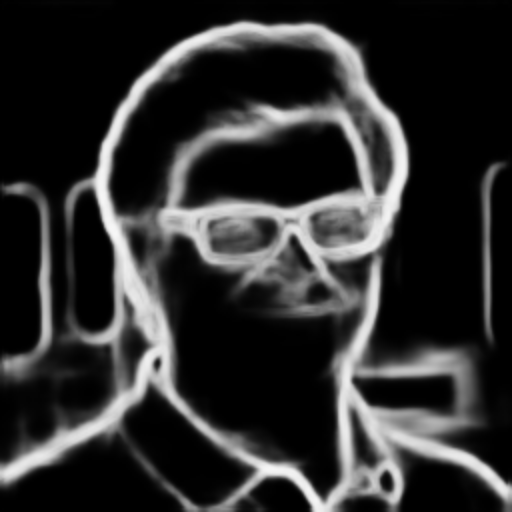

In [18]:

#pipe.enable_xformers_memory_efficient_attention()


image = load_image(
    "/data1/jiayu_xiao/project/custom-diffusion/data/fame/yann-lecun.jpg"
)
image

torch.cuda.set_device('cuda:2')
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

apply_hed = HEDdetector()

low_threshold = 100
high_threshold = 200




input_image = HWC3(image)
detected_map = apply_hed.forward(resize_image(input_image, 256))



detected_map = HWC3(detected_map)
img = resize_image(detected_map, 512) 
H, W, C = img.shape

detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_LINEAR)
print(detected_map.min(), detected_map.max())
detected_map = Image.fromarray(detected_map)
detected_map




  0%|          | 0/20 [00:00<?, ?it/s]

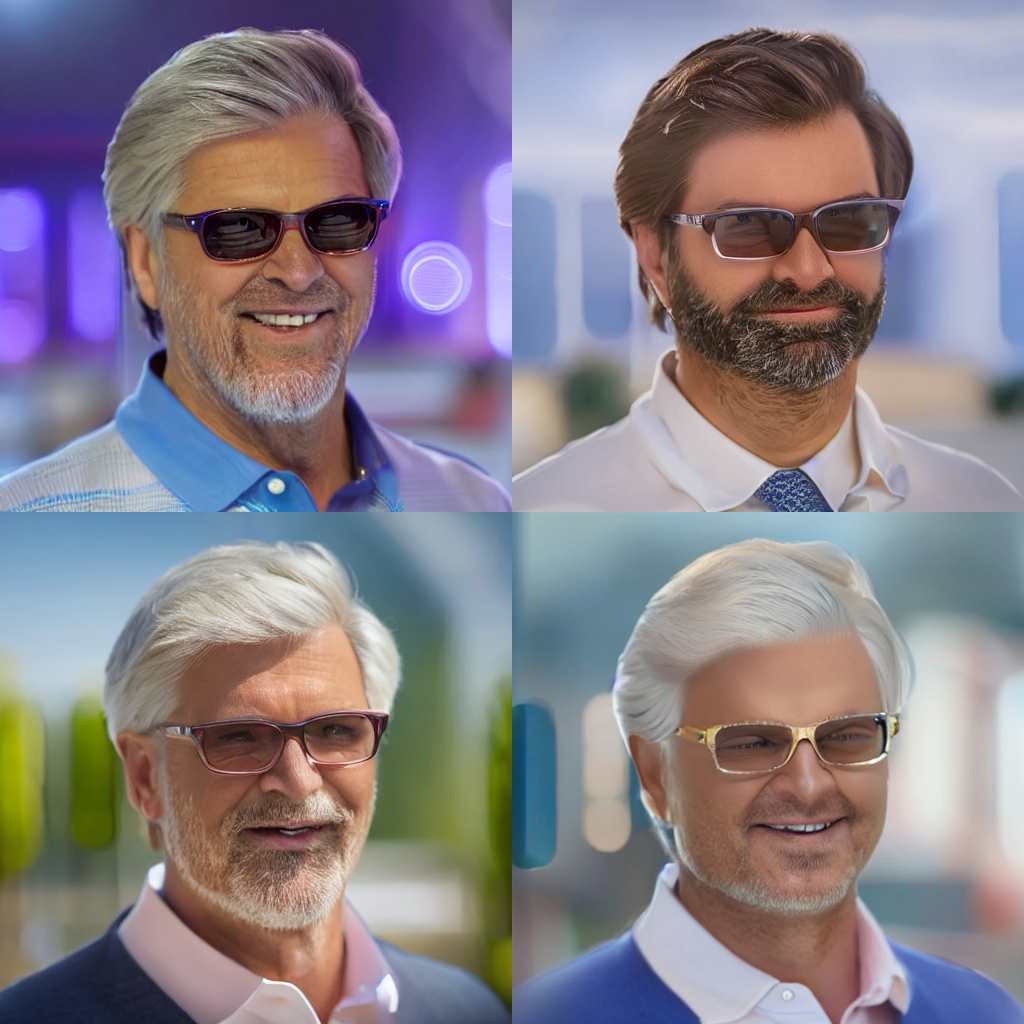

In [17]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["a man", "a man", "a man", "a man"]]
generator = [torch.Generator(device="cpu").manual_seed(i) for i in range(len(prompt))]

pipe.to('cuda')

output = pipe(
    prompt,
    detected_map,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    num_inference_steps=20,
    generator=generator,
    controlnet_conditioning_scale=0.3,
)

image_grid(output.images, 2, 2)